In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()
    def render_np(self):
        displ_board = np.zeros(( 4,  4), dtype = np.uint8)
        displ_board[self.board.components['Player'].pos] = 1
        displ_board[self.board.components['Goal'].pos] = 2
        displ_board[self.board.components['Pit'].pos] = 3
        displ_board[self.board.components['Wall'].pos] = 4
        return displ_board

In [3]:
game = Gridworld(size=4, mode='static')
game.render_np()

array([[2, 3, 0, 1],
       [0, 4, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [4]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [5]:
def test_model(model,mode='static', display=True):
    i = 0
    w, h = 8, 100
    matrix = [[0 for x in range(w)] for y in range(h)] 
    test_game = Gridworld(mode=mode)
    state_ = test_game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    counter = 0
    while(status == 1): #A
        matrix[counter][0] = (str(test_game.board.components['Player'].pos))
        matrix[counter][5] = (str(test_game.board.components['Pit'].pos))
        matrix[counter][6] = (str(test_game.board.components['Goal'].pos))
        matrix[counter][7] = (str(test_game.board.components['Wall'].pos))
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        matrix[counter][2] = action 
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        matrix[counter][1] = (str(test_game.board.components['Player'].pos))
        state_ = test_game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        matrix[counter][3] = reward
        matrix[counter][4] = i
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        counter = counter + 1 
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win


# Static Mode

D:\Conda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Games played: 1000, # of wins: 194
Win percentage: 19.400000000000002%


Text(0, 0.5, 'Loss')

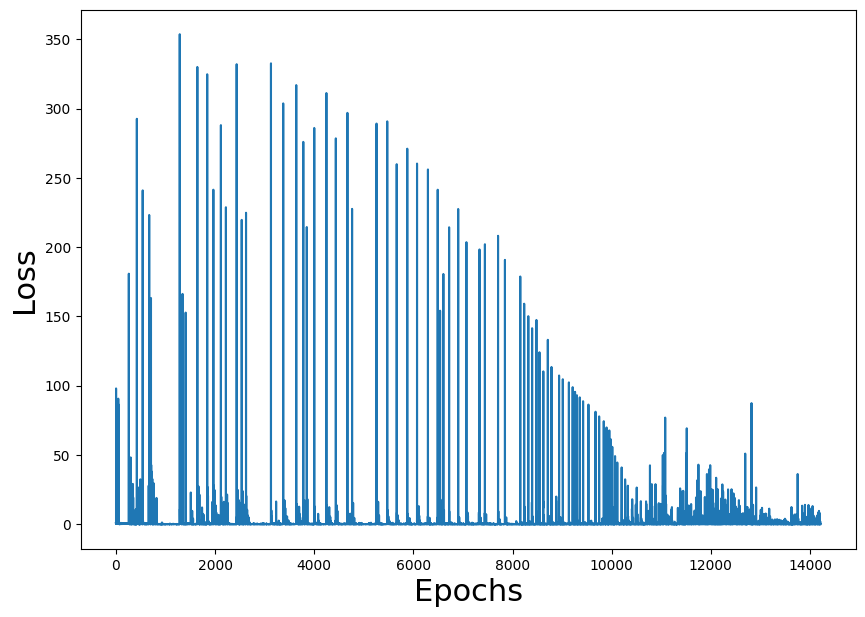

In [6]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
l1 = 16
l2 = 100
l3 = 90
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

epochs = 500
losses = [] #A
w, h = 17, 100000
matrix = [[0 for x in range(w)] for y in range(h)] 
counter = 0
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C
    state_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0 #D
    state1 = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        matrix[counter][5] = epsilon 
        matrix[counter][0] = i + 1
        matrix[counter][1] = (str(game.board.components['Player'].pos))
        matrix[counter][11] = (str(game.board.components['Pit'].pos))
        matrix[counter][12] = (str(game.board.components['Goal'].pos))
        matrix[counter][13] = (str(game.board.components['Wall'].pos))

        qval = model(state1) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            matrix[counter][4] = 1 
            action_ = np.random.randint(0,4)
        else:
            matrix[counter][4] = 0 
            action_ = np.argmax(qval_)
        action = action_set[action_] #J
        matrix[counter][6] = action 
        matrix[counter][14] = round(list(model.parameters())[5][action_].item(),6)
        game.makeMove(action) #K
        state2_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,16))
        maxQ = torch.max(newQ) #M
        matrix[counter][8] = maxQ.item()
        if reward == -1: #N
            matrix[counter][3] = -1 
            Y = reward + (gamma * maxQ)
        else:
            matrix[counter][3] = reward 
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        

        matrix[counter][7] = X.item()
        matrix[counter][9] = Y.item()
        loss = loss_fn(X, Y) #P
        matrix[counter][10] = loss.item()
#             print(i, loss.item())
#             clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        matrix[counter][2] = (str(game.board.components['Player'].pos))
        matrix[counter][15] = round(list(model.parameters())[5][action_].item(),6)
        matrix[counter][16] = counter + 1

        counter = counter + 1 
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='static', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [7]:
import pandas as pd
column_names = ["Epochs","Cuttent_State", "Next_State", "Reward","Epsilon_Boolean", "Epsilon", "Action",
                "Current_Q_Value", "Next_Q_Value","Reawrd_Plus_Next_Q_Value", "Loss",
                "Pit_Position", "Goal_Position", "Wall_Position",
                "Weight_Current",
                "Weight__Next","Step" 
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
# mapping = {"Epochs":"Epochs","Next_State":"Next_State","Reward":"Reward","Cuttent_State":"Cuttent_State",
#            "Epsilon_Boolean":"Epsilon_Boolean","Epsilon":"Epsilon",
#            "Action":"Action", "Current_Q_Value":"Current_Q_Value",
#            "Next_Q_Value":"Next_Q_Value", "Reawrd_Plus_Next_Q_Value":"Reawrd_Plus_Next_Q_Value",
#            "Loss":"Loss","Pit_Position":"Pit_Position", "Goal_Position": "Goal_Position",
#            "Wall_Position":"Wall_Position",
#            'Model_Param_Current[0]': 'Current_Model_Parameters', 'Model_Param_Current[1]': 'Current_Model_Parameters',
#            'Model_Param_Current[2]': 'Current_Model_Parameters', 'Model_Param_Current[3]': 'Current_Model_Parameters',
#            'Model_Param_Next[0]': 'Next_Model_Parameters', 'Model_Param_Next[1]': 'Next_Model_Parameters',
#            'Model_Param_Next[2]': 'Next_Model_Parameters', 'Model_Param_Next[3]': 'Next_Model_Parameters',   
#           }
# df = df.set_index('Step').groupby(mapping, axis = 1).sum()
  
# df.reset_index(level = 0)
df['Weight_Diff'] = df['Weight__Next'] - df['Weight_Current']
df['Gradient'] = df['Weight_Diff'] / learning_rate
df
sliced_df = pd.concat([df.head(10), df.tail(10)])
sliced_df

,Epochs,Cuttent_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,Loss,Pit_Position,Goal_Position,Wall_Position,Weight_Current,Weight__Next,Step,Weight_Diff,Gradient
0,1,"(0, 3)","(1, 3)",-1,1,1.000,d,0.025405,0.089488,-0.919461,0.892772,"(0, 1)","(0, 0)","(1, 1)",-0.071608,-0.073498,1,-0.001890,-1.890
1,1,"(1, 3)","(0, 3)",-1,1,1.000,u,-0.078979,0.175247,-0.842277,0.582625,"(0, 1)","(0, 0)","(1, 1)",0.004961,0.003434,2,-0.001527,-1.527
2,1,"(0, 3)","(0, 3)",-1,1,1.000,r,0.177382,0.176354,-0.841281,1.037675,"(0, 1)","(0, 0)","(1, 1)",-0.015906,-0.017944,3,-0.002038,-2.038
3,1,"(0, 3)","(0, 2)",-1,1,1.000,l,-0.106561,0.106600,-0.904060,0.636006,"(0, 1)","(0, 0)","(1, 1)",-0.085343,-0.086938,4,-0.001595,-1.595
4,1,"(0, 2)","(0, 1)",-10,1,1.000,l,-0.100830,0.127904,-10.000000,97.993568,"(0, 1)","(0, 0)","(1, 1)",-0.086938,-0.106736,5,-0.019798,-19.798
5,2,"(0, 3)","(1, 3)",-1,1,0.998,d,0.016348,0.085716,-0.922856,0.882104,"(0, 1)","(0, 0)","(1, 1)",-0.073498,-0.075376,6,-0.001878,-1.878
6,2,"(1, 3)","(0, 3)",-1,1,0.998,u,-0.093418,0.162333,-0.853901,0.578335,"(0, 1)","(0, 0)","(1, 1)",0.003434,0.001913,7,-0.001521,-1.521
7,2,"(0, 3)","(1, 3)",-1,1,0.998,d,-0.005141,0.086542,-0.922112,0.840836,"(0, 1)","(0, 0)","(1, 1)",-0.075376,-0.077210,8,-0.001834,-1.834
8,2,"(1, 3)","(1, 3)",-1,1,0.998,r,0.087121,0.086940,-0.921754,1.017829,"(0, 1)","(0, 0)","(1, 1)",-0.017944,-0.019961,9,-0.002017,-2.017
9,2,"(1, 3)","(2, 3)",-1,1,0.998,d,-0.025422,0.105483,-0.905066,0.773772,"(0, 1)","(0, 0)","(1, 1)",-0.077210,-0.078969,10,-0.001759,-1.759


In [8]:
df.to_csv('Modification.csv')

In [9]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 96
Win percentage: 9.6%
